 <img src="https://datacube.remote-sensing.org/wp-content/uploads/2021/03/cube_namibia.png" align="left" width='70' alt="sa_logo">
          <img src="https://datacube.remote-sensing.org/wp-content/uploads/2021/02/ci_logo_navbar.png" align="right" width='180' alt="eo_logo">

## Sentinel-1: Water Detection

In [51]:
import datacube
import geopandas as gpd
from odc.ui import with_ui_cbk
import xarray as xr
import seaborn as sns
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import matplotlib.pyplot as plt

In [6]:
dc = datacube.Datacube(app = 's1_water')

In [28]:
gdf = gpd.read_file('data/example.shp')

In [29]:
longitude_extents = (gdf.total_bounds[0] , gdf.total_bounds[2] )
latitude_extents  = (gdf.total_bounds[1] , gdf.total_bounds[3] )
latitude_extents

(-25.763999530488093, -25.69548011202764)

In [56]:
ds_s1 = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          time = ('2020-01-01', '2020-04-24'),
                          product = 's1_rtc',
                        output_crs = "EPSG:32734",
                        resolution = (-10,10),
                         progress_cbk=with_ui_cbk()) 

In [31]:
ds_s1

<xarray.Dataset>
Dimensions:      (time: 23, y: 834, x: 889)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-06T03:19:00.409374 ... 2019-04...
  * y            (y) float64 7.116e+06 7.116e+06 ... 7.108e+06 7.108e+06
  * x            (x) float64 1.554e+06 1.554e+06 ... 1.563e+06 1.563e+06
    spatial_ref  int32 32734
Data variables:
    vv           (time, y, x) float32 0.2029 0.2029 0.2126 ... 0.1481 0.1947
    vh           (time, y, x) float32 0.08333 0.08333 ... 0.03455 0.05947
    angle        (time, y, x) uint8 35 35 36 36 37 37 36 ... 41 41 41 40 40 40
    area         (time, y, x) float32 1.417 1.417 1.384 ... 1.207 1.207 1.194
    mask         (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

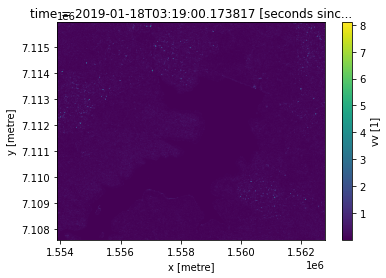

In [54]:
ds_s1.vv.isel(time=2).plot()

In [45]:
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

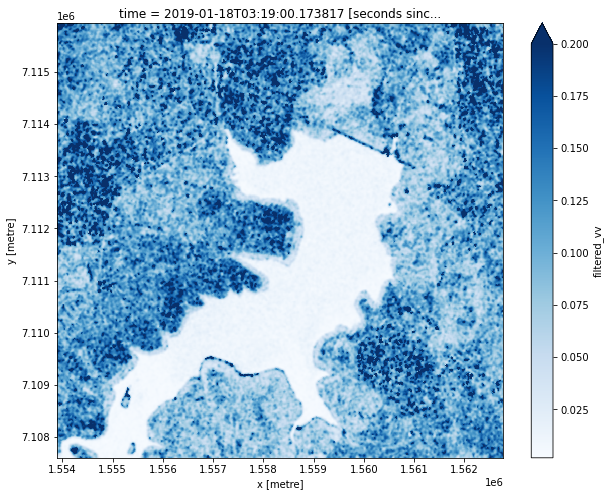

In [48]:
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=5)
ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=5)

subset = ds_s1.filtered_vv.isel(time = 2)
subset.plot(cmap='Blues',  vmax=0.2, figsize=(10,8))

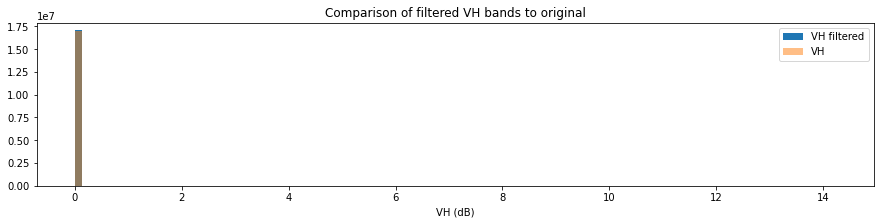

In [52]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=100, label="VH filtered")
ds_s1.vh.plot.hist(bins=100, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

AttributeError: 'Dataset' object has no attribute 'VV'

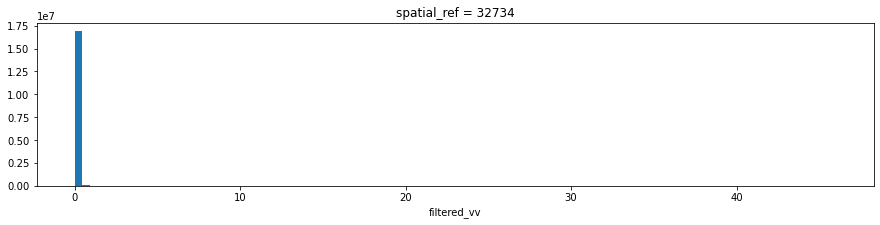

In [53]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv.plot.hist(bins=100, label="VV filtered")
ds_s1.VV.plot.hist(bins=100, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

In [ ]:
threshold=-21

fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=100, label="VH filtered")
ax.axvspan(xmin=-40.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-0.5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

In [ ]:
filtered = ds_s1.VH.groupby("time").apply(lee_filter, size=7)
water_data_array = filtered < threshold
ds_s1["water"] = water_data_array.to_dataset(name="s1_water").s1_water

In [ ]:
plt.figure(figsize=(15, 12))
ds_s1.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

In [ ]:
plt.figure(figsize=(15, 12))
ds_s1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values")
plt.show()